# Bước 1: Tải dữ liệu từ vnstock

In [ ]:
pip install vnstock

In [ ]:
from vnstock import *

In [ ]:
company = 'HPG'
company1 = 'NKG'
company2 = 'HSG'

df =  stock_historical_data(symbol=company,
                            start_date="2012-03-20",
                            end_date='2024-06-20', resolution='1D', type='stock')
df1 =  stock_historical_data(symbol=company1,
                            start_date="2012-03-20",
                            end_date='2024-06-20', resolution='1D', type='stock')
df2 =  stock_historical_data(symbol=company2,
                            start_date="2012-03-20",
                            end_date='2024-06-20', resolution='1D', type='stock')

In [ ]:
df.to_csv(f'{company}_data.csv', index=False)
df1.to_csv(f'{company1}_data.csv', index=False)
df2.to_csv(f'{company2}_data.csv', index=False)


# Bước 2: Import các thư viện cần thiết

In [ ]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.1 MB/s eta 0:00:00


In [ ]:
import math
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt #vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model #tải mô hình

#các lớp để xây dựng mô hình
from keras.models import Sequential #đầu vào
from keras.layers import LSTM #học phụ thuộc
from keras.layers import Dropout #tránh học tủ
from keras.layers import Dense #đầu ra
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score #đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error #đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error #đo % sai số tuyệt đối trung bình

# time series
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

# Bước 3: Đọc dữ liệu

In [ ]:
# Tạo quyền truy cập với google drive

# from google.colab import drive
# drive.mount('/content/drive')


In [ ]:
# đọc dữ liệu từ file csv
# df = pd.read_csv('/content/drive/MyDrive/Stock_Data/VNM_2012-2024.csv', index_col=0)
df = pd.read_csv(f'{company}_data.csv', index_col=0, parse_dates=True)
df1 = pd.read_csv(f'{company1}_data.csv', index_col=0, parse_dates=True)
df2 = pd.read_csv(f'{company2}_data.csv', index_col=0, parse_dates=True)



In [ ]:
df = df.drop(columns=["ticker"])
df.shape

(3055, 5)

# Bước 4: Khám phá và trực quan hóa dữ liệu

In [ ]:
df.head()

,open,high,low,close,volume
time,,,,,
2012-03-26,1200,1200,1180,1180,412710
2012-03-27,1170,1190,1170,1170,964010
2012-03-28,1160,1170,1160,1170,282250
2012-03-29,1160,1180,1160,1170,438730
2012-03-30,1180,1200,1170,1180,685020


In [ ]:
df.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [ ]:
#xác định kiểu dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3055 entries, 2012-03-26 to 2024-06-20
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   open    3055 non-null   int64
 1   high    3055 non-null   int64
 2   low     3055 non-null   int64
 3   close   3055 non-null   int64
 4   volume  3055 non-null   int64
dtypes: int64(5)
memory usage: 143.2 KB


In [ ]:
#mô tả bộ dữ liệu
df.describe()

,open,high,low,close,volume
count,3055.000000,3055.000000,3055.000000,3055.000000,3.055000e+03
mean,11924.791162,12087.384943,11766.991489,11921.074304,9.725531e+06
std,9905.855879,10034.565512,9770.034969,9890.254202,1.200764e+07
min,970.000000,1010.000000,970.000000,990.000000,6.000000e+03
25%,3750.000000,3810.000000,3725.000000,3760.000000,9.977750e+05
50%,9190.000000,9320.000000,9110.000000,9190.000000,4.367480e+06
75%,19090.000000,19410.000000,18820.000000,19050.000000,1.544255e+07
max,39910.000000,40180.000000,39560.000000,39910.000000,9.965880e+07


In [ ]:
df.head()

,open,high,low,close,volume
time,,,,,
2012-03-26,1200,1200,1180,1180,412710
2012-03-27,1170,1190,1170,1170,964010
2012-03-28,1160,1170,1160,1170,282250
2012-03-29,1160,1180,1160,1170,438730
2012-03-30,1180,1200,1170,1180,685020


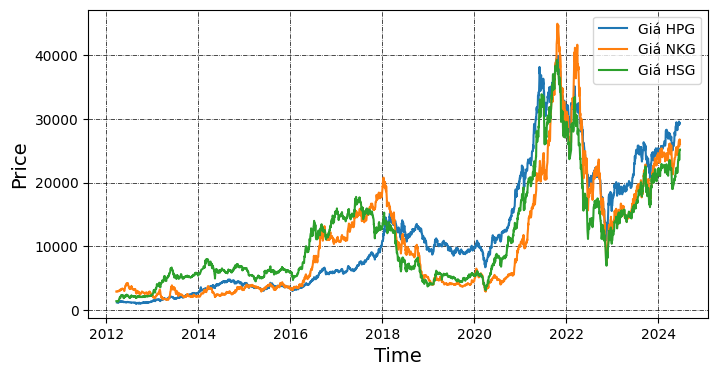

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_facecolor('white')  # Đặt màu nền của khu vực vẽ là màu trắng
ax.plot(df['close'], label="Giá HPG")
ax.plot(df1['close'], label="Giá NKG")
ax.plot(df2['close'], label="Giá HSG")

ax.set_ylabel('Price', fontsize=14)
ax.set_xlabel('Time', fontsize=14)
ax.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
ax.legend()

plt.show()

In [ ]:
pip install mpl-finance

In [ ]:
pip install --upgrade mplfinance

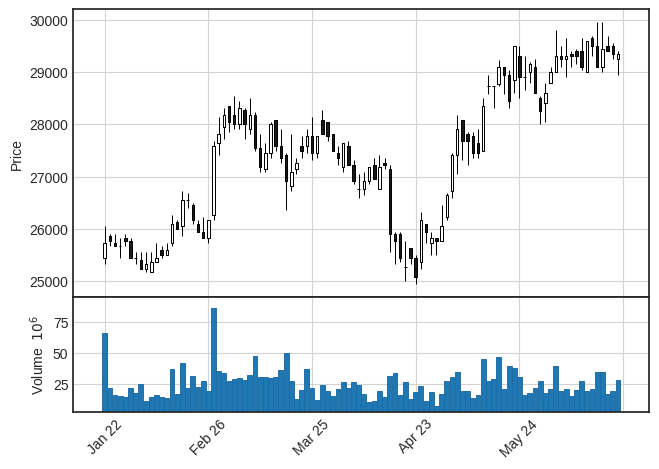

In [ ]:
import mplfinance as mpf

my_style = mpf.make_mpf_style(base_mpl_style='seaborn-white',
                              facecolor='white',
                              gridcolor='lightgray')

df.index.name = 'time'

mpf.plot(df.tail(100),type='candle',  style=my_style,volume=True)
plt.show()

In [ ]:
songay = 20
ma = df.close.rolling(songay).mean()
std = df['close'].rolling(window=songay).std()

# Tính toán dải Bollinger Band
upper_band = ma + 2 * std
lower_band = ma - 2 * std

ma

time
2012-03-26        NaN
2012-03-27        NaN
2012-03-28        NaN
2012-03-29        NaN
2012-03-30        NaN
               ...   
2024-06-14    29057.0
2024-06-17    29075.0
2024-06-18    29097.5
2024-06-19    29142.5
2024-06-20    29135.0
Name: close, Length: 3055, dtype: float64

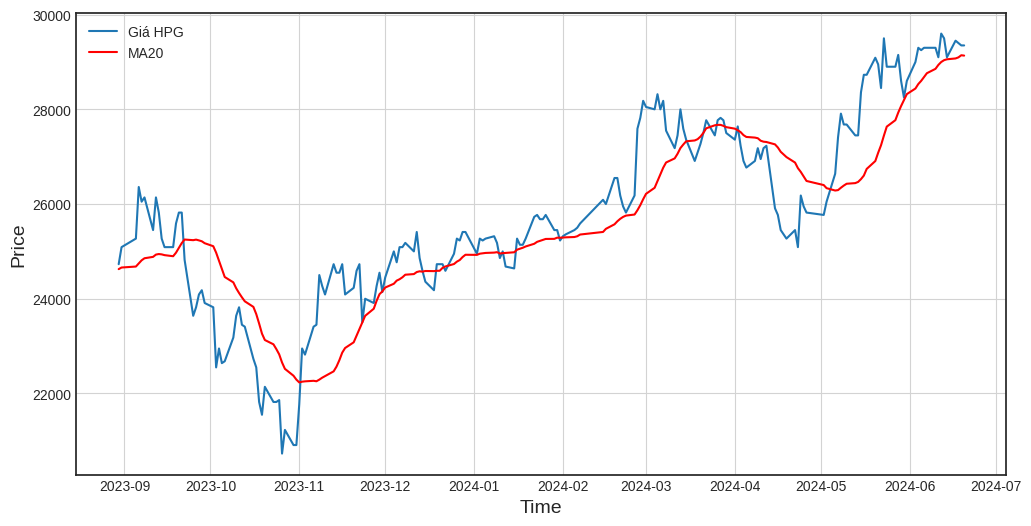

In [ ]:
# Tạo figure và axes
fig, ax = plt.subplots(figsize=(12, 6), facecolor='white')
ax.set_facecolor('white')  # Đặt màu nền của khu vực vẽ là màu trắng

# Vẽ dữ liệu lên axes
ax.plot(df.close.tail(200), label='Giá HPG')
ax.plot(ma.tail(200), 'r', label=f'MA{songay}')
ax.set_ylabel('Price', fontsize=14)
ax.set_xlabel('Time', fontsize=14)
ax.grid(True)
ax.legend()

# Hiển thị biểu đồ
plt.show()

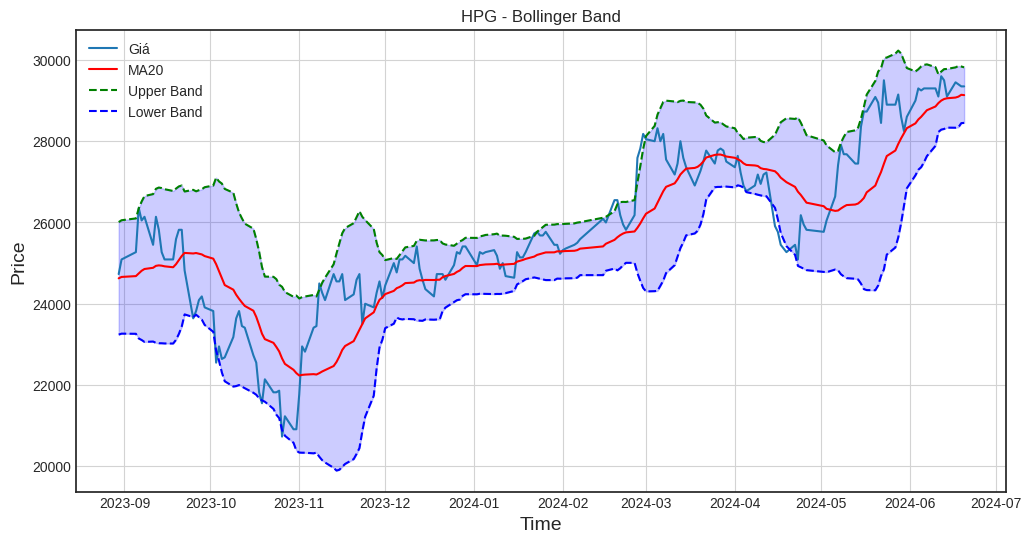

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['close'].tail(200), label='Giá')
plt.plot(ma.tail(200), 'r', label=f'MA{songay}')
plt.plot(upper_band.tail(200), 'g--', label='Upper Band')
plt.plot(lower_band.tail(200), 'b--', label='Lower Band')
plt.xlabel("Time",fontsize=14)
plt.ylabel("Price",fontsize=14)

plt.fill_between(df.index[-200:], lower_band[-200:], upper_band[-200:], color='blue', alpha=0.2)  # Đổ màu dải Bollinger Band
plt.grid(True)
plt.title('HPG - Bollinger Band')
plt.legend()
plt.show()

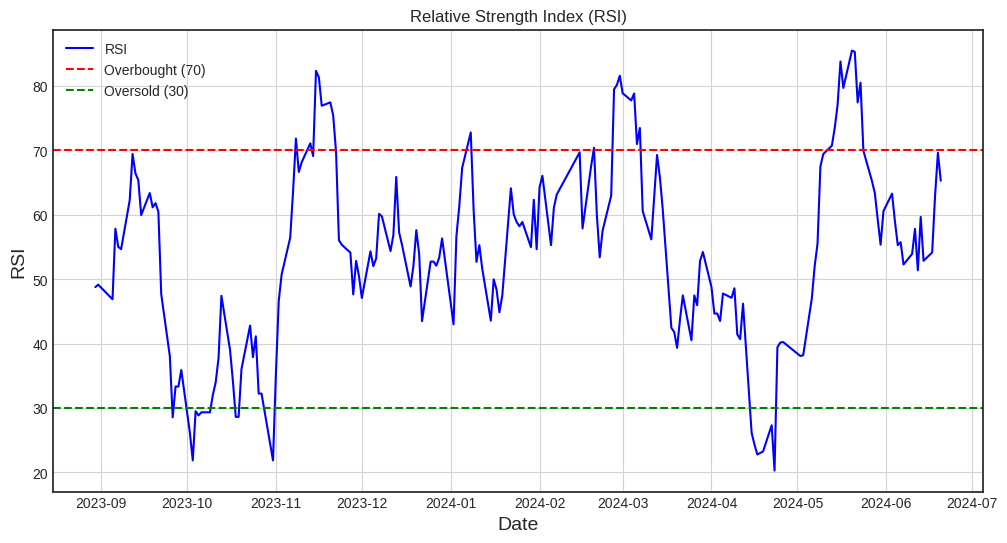

In [ ]:
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

# Tính toán RSI
df['rsi'] = calculate_rsi(df['close'])

# Vẽ biểu đồ RSI (tuỳ chọn)
plt.figure(figsize=(12, 6))
plt.plot(df['rsi'].tail(200), label='RSI', color='b')
plt.axhline(y=70, color='r', linestyle='--', label='Overbought (70)')
plt.axhline(y=30, color='g', linestyle='--', label='Oversold (30)')
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date', fontsize=14)
plt.ylabel('RSI', fontsize=14)
plt.legend()
plt.show()

Time series

<Axes: ylabel='Density'>

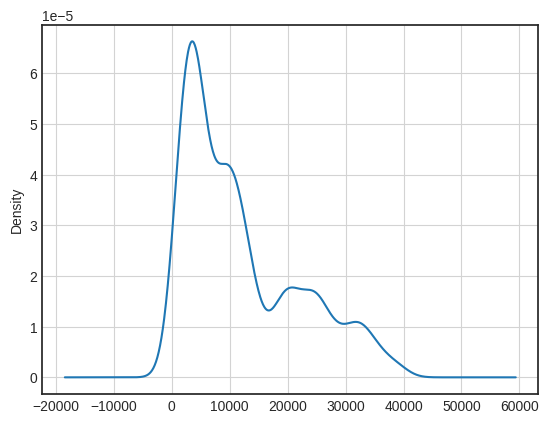

In [ ]:
#Distribution of the dataset
df_close = df['close']
df_close.plot(kind='kde')

Test for Stationarity

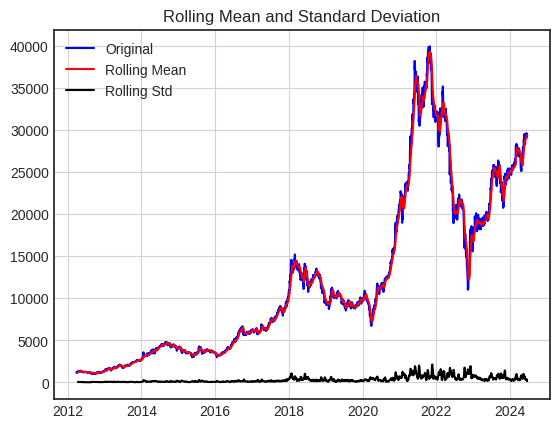

Results of dickey fuller test
Test Statistic                  -0.834903
p-value                          0.808654
No. of lags used                22.000000
Number of observations used   3032.000000
critical value (1%)             -3.432509
critical value (5%)             -2.862494
critical value (10%)            -2.567278
dtype: float64


In [ ]:
#ADF (Augmented Dickey-Fuller) Test
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    # Output for ADF test
    output = pd.Series(adft[0:4], index=['Test Statistic', 'p-value', 'No. of lags used', 'Number of observations used'])

    # Adding critical values to output
    for key, value in adft[4].items():
        output['critical value (%s)' % key] = value

    # Formatting the output to avoid scientific notation
    with pd.option_context('display.float_format', '{:.6f}'.format):
        print(output)
test_stationarity(df_close)

We can’t rule out the Null hypothesis because the p-value is bigger than 0.05. Additionally, the test statistics exceed the critical values. As a result, the data is nonlinear.

<Figure size 640x480 with 0 Axes>

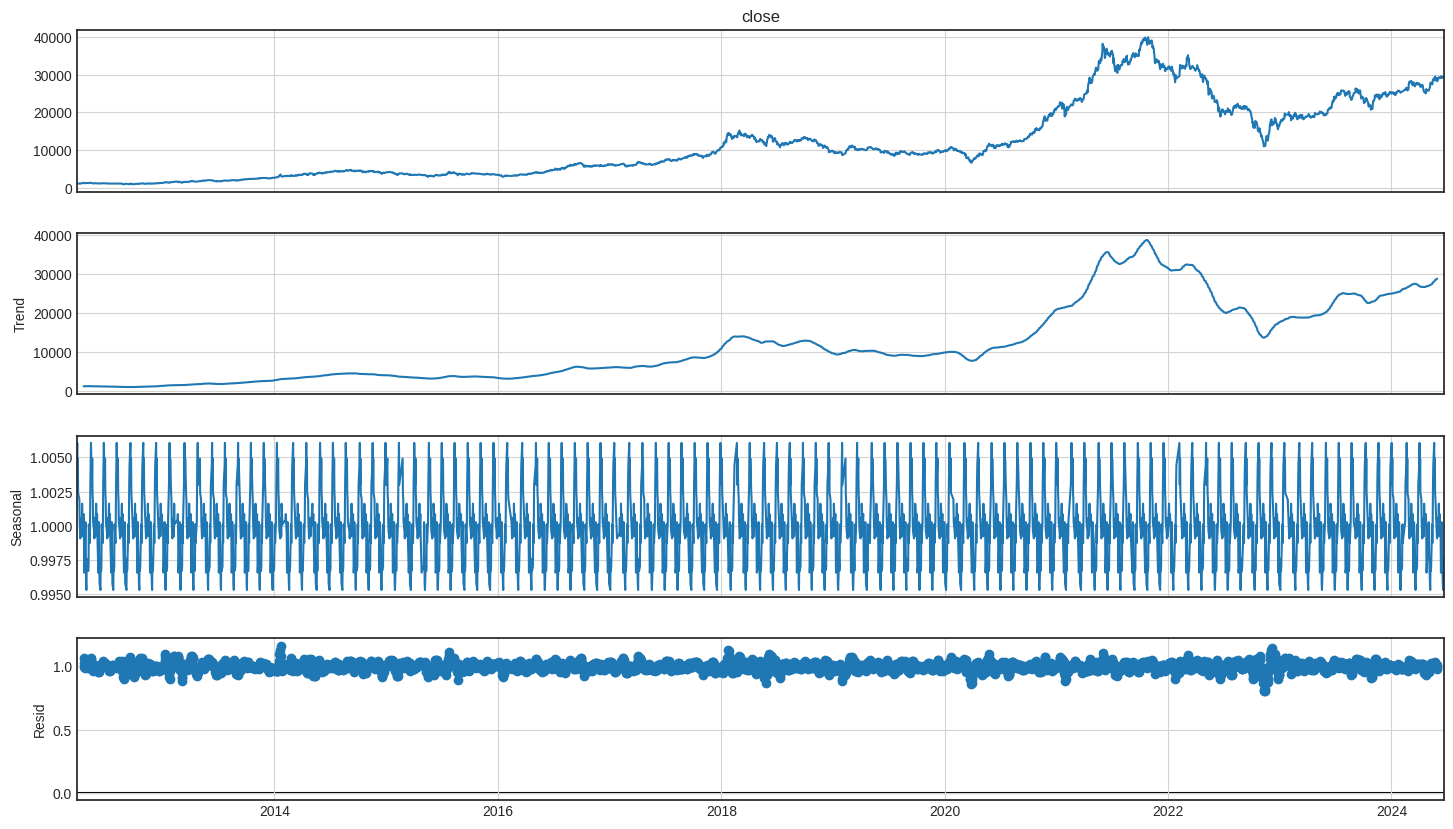

In [ ]:
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

using adf với log

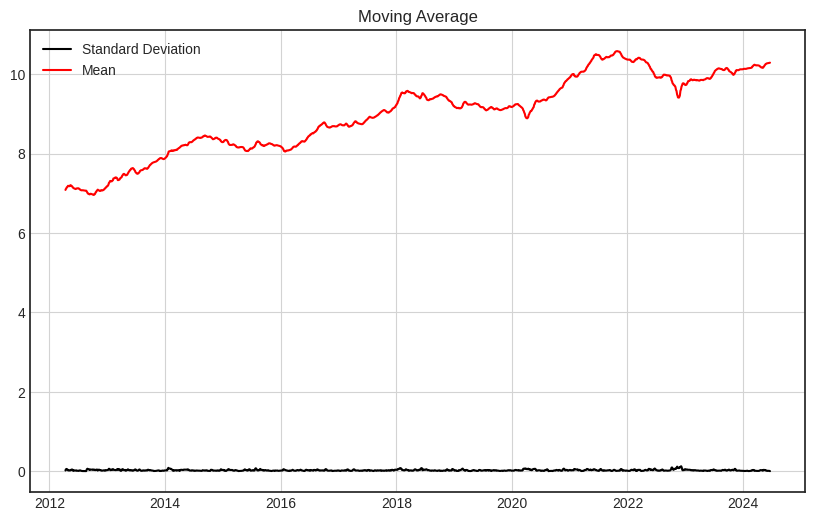

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(abs(df_close))
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

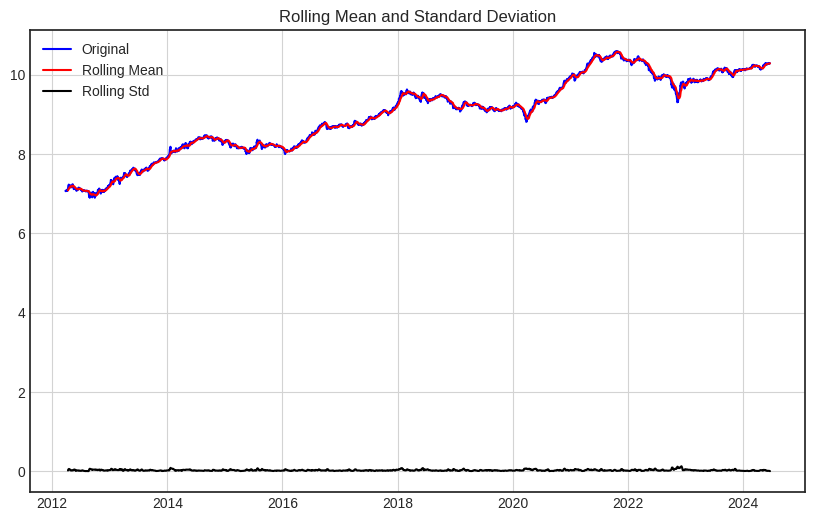

Results of dickey fuller test
Test Statistic                  -1.219124
p-value                          0.665315
No. of lags used                14.000000
Number of observations used   3040.000000
critical value (1%)             -3.432503
critical value (5%)             -2.862491
critical value (10%)            -2.567276
dtype: float64


In [ ]:
test_stationarity(df_log)

In [ ]:
# test_stationarity(df_log)

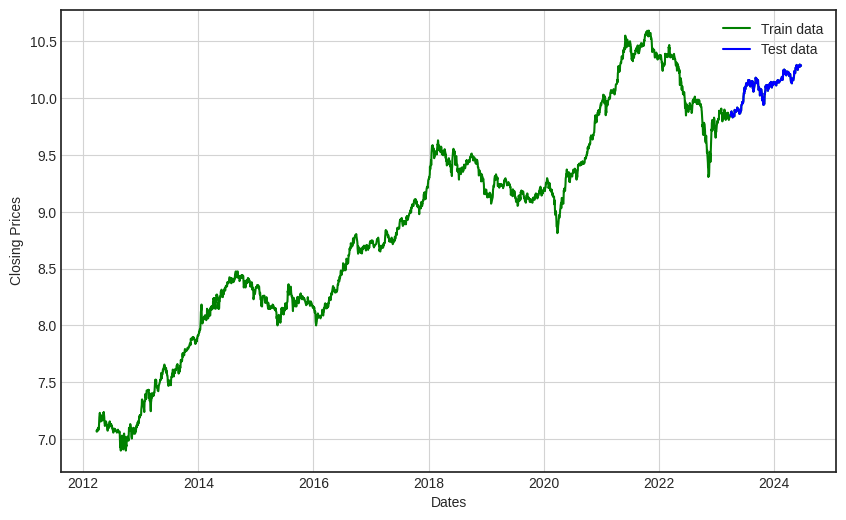

In [ ]:
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13190.050, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13192.972, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-13193.093, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13186.175, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-13191.184, Time=0.51 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-13191.298, Time=1.63 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-13189.881, Time=4.51 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-13189.694, Time=0.38 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 8.626 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2746
Model:               SARIMAX(0, 1, 1)   Log Likelihood                6599.547
Date:                Fri, 28 Jun 2024   AIC                         -13193.093
Time:               

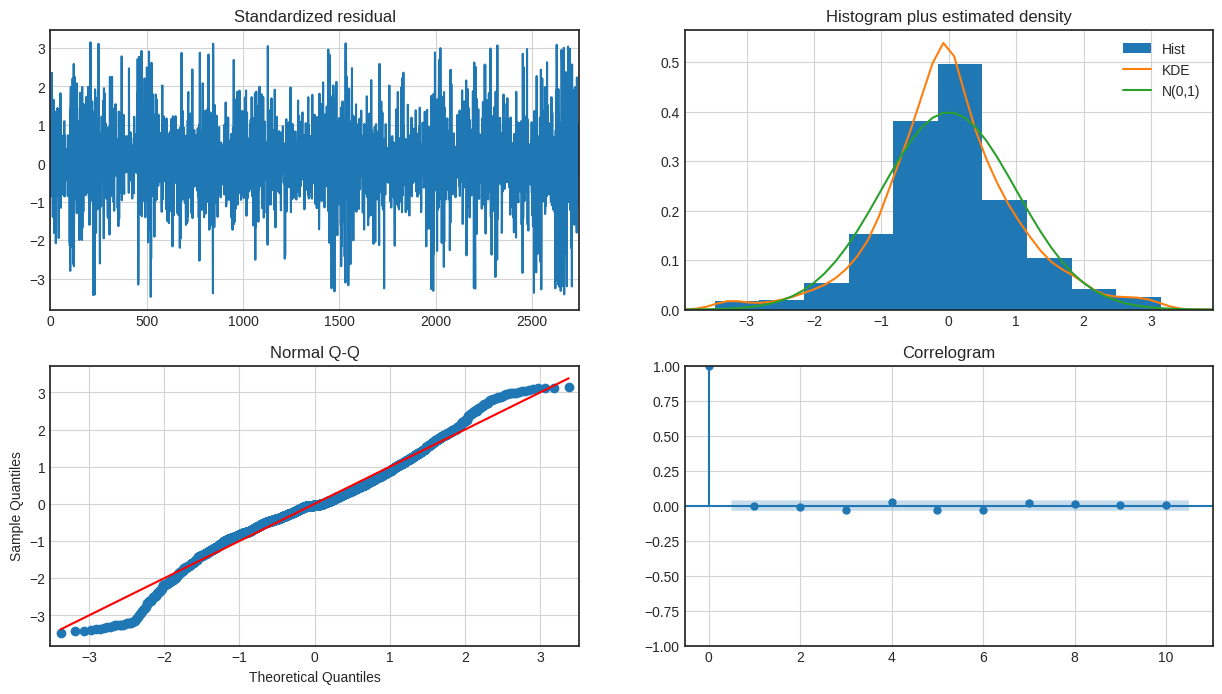

In [ ]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
# Giả sử train_data đã được định nghĩa
# Tạo mô hình ARIMA
model = ARIMA(train_data, order=(0,1,1))

# Huấn luyện mô hình
fitted = model.fit()

# In ra bản tóm tắt của mô hình đã huấn luyện
print(fitted.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 2746
Model:                 ARIMA(0, 1, 1)   Log Likelihood                6596.847
Date:                Fri, 28 Jun 2024   AIC                         -13189.694
Time:                        05:56:15   BIC                         -13177.858
Sample:                             0   HQIC                        -13185.417
                               - 2746                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0447      0.015      2.961      0.003       0.015       0.074
sigma2         0.0005   1.02e-05     47.105      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.01   Jarque-

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


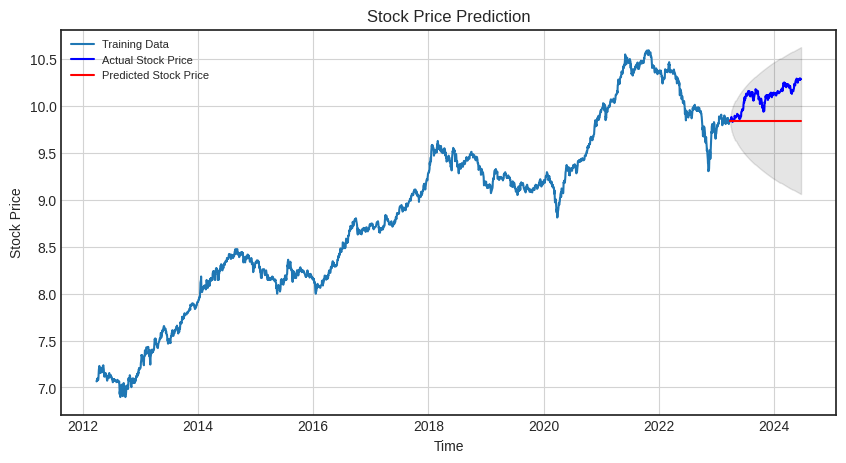

In [ ]:
# Dự báo
forecast_steps = len(test_data)
forecast = fitted.get_forecast(steps=forecast_steps)

# Dự báo giá trị và khoảng tin cậy
fc = forecast.predicted_mean
forecast_array = fc.tolist()
conf = forecast.conf_int(alpha=0.05)
conf.index = test_data.index


# Tạo series từ kết quả dự báo
# fc_series = pd.Series(fc, index=test_data.index)

fc_series = pd.DataFrame(forecast_array, index=test_data.index, columns=['Forecast'])
lower_series = pd.Series(conf.iloc[:, 0])
upper_series = pd.Series(conf.iloc[:, 1])

# Vẽ biểu đồ
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label='Training Data')
plt.plot(test_data, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='red', label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.10)
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [ ]:
# report performance
mse = mean_squared_error(test_data, forecast_array)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, forecast_array)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, forecast_array))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(forecast_array - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))


MSE: 0.07915116678035038
MAE: 0.25373722900914975
RMSE: 0.28133817156644486
MAPE: 0.024983612940076803


# Bước 5: Tiền xử lý dữ liệu


In [ ]:
from sklearn.preprocessing import MinMaxScaler

dùng mỗi cột close

In [ ]:
# train_size_percent = 0.80
n_step = 15
lstm_layers = 50
epochs = 10
batch_size = 32
features = 1

# Tỷ lệ phần trăm dành cho tập huấn luyện và kiểm tra
train_size_percent = 0.70
test_size_percent = 0.15

closedf = df[["close"]]

scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = scaler.fit_transform(closedf)

# Tính số lượng hàng cho tập huấn luyện
n_train_rows = int(df_scaled.shape[0] * train_size_percent)

# Tính số lượng hàng cho tập kiểm tra
n_test_rows = int(df_scaled.shape[0] * test_size_percent)

# Chia dữ liệu thành train, test và validation
train_scaled = df_scaled[:n_train_rows]
valid_scaled = df_scaled[n_train_rows:n_train_rows + n_test_rows]
test_scaled = df_scaled[n_train_rows + n_test_rows:]

# Kiểm tra kích thước của các tập dữ liệu
print(f"Train set shape: {train_scaled.shape}")
print(f"Test set shape: {test_scaled.shape}")
print(f"Validation set shape: {valid_scaled.shape}")


# convert an array of values into a dataset matrix

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step):
        ###i=0, 0,1,2,3-----99   100
        dataX.append(dataset[i:(i+time_step), 0])
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

X_train, y_train = create_dataset(train_scaled, n_step)
X_test, y_test = create_dataset(test_scaled, n_step)
X_valid, y_valid = create_dataset(valid_scaled, n_step)

print("x_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", X_test.shape)
print("y_test", y_test.shape)
print("x_valid: ", X_valid.shape)
print("y_valid", y_valid.shape)

# reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , features)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , features)
X_valid = X_valid.reshape(X_valid.shape[0],X_valid.shape[1] , features)


print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("X_valid: ", X_valid.shape)

# reshape input to be [samples, features] which is required for LSTM
y_train = y_train.reshape(y_train.shape[0] , features)
y_test = y_test.reshape(y_test.shape[0], features)
y_valid = y_valid.reshape(y_valid.shape[0], features)


print("y_train: ", y_train.shape)
print("y_test: ", X_test.shape)
print("y_valid: ", y_valid.shape)

Train set shape: (2138, 1)
Test set shape: (459, 1)
Validation set shape: (458, 1)
x_train:  (2123, 15)
y_train:  (2123,)
x_test:  (444, 15)
y_test (444,)
x_valid:  (443, 15)
y_valid (443,)
X_train:  (2123, 15, 1)
X_test:  (444, 15, 1)
X_valid:  (443, 15, 1)
y_train:  (2123, 1)
y_test:  (444, 15, 1)
y_valid:  (443, 1)


# Bước 6: Phát triển các mô hình máy học

In [ ]:
# train_size_percent = 0.80
n_step = 15
lstm_layers = 50
epochs = 10
batch_size = 32
features = 1

# Tỷ lệ phần trăm dành cho tập huấn luyện và kiểm tra
train_size_percent = 0.70
test_size_percent = 0.15

closedf = df[["close"]]

scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = scaler.fit_transform(closedf)

# Tính số lượng hàng cho tập huấn luyện
n_train_rows = int(df_scaled.shape[0] * train_size_percent)

# Tính số lượng hàng cho tập kiểm tra
n_test_rows = int(df_scaled.shape[0] * test_size_percent)

# Chia dữ liệu thành train, test và validation
train_scaled = df_scaled[:n_train_rows]
valid_scaled = df_scaled[n_train_rows:n_train_rows + n_test_rows]
test_scaled = df_scaled[n_train_rows + n_test_rows:]

# Kiểm tra kích thước của các tập dữ liệu
print(f"Train set shape: {train_scaled.shape}")
print(f"Test set shape: {test_scaled.shape}")
print(f"Validation set shape: {valid_scaled.shape}")


# convert an array of values into a dataset matrix

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step):
        ###i=0, 0,1,2,3-----99   100
        dataX.append(dataset[i:(i+time_step), 0])
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

X_train, y_train = create_dataset(train_scaled, n_step)
X_test, y_test = create_dataset(test_scaled, n_step)
X_valid, y_valid = create_dataset(valid_scaled, n_step)

print("x_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", X_test.shape)
print("y_test", y_test.shape)
print("x_valid: ", X_valid.shape)
print("y_valid", y_valid.shape)

# reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , features)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , features)
X_valid = X_valid.reshape(X_valid.shape[0],X_valid.shape[1] , features)


print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("X_valid: ", X_valid.shape)

# reshape input to be [samples, features] which is required for LSTM
y_train = y_train.reshape(y_train.shape[0] , features)
y_test = y_test.reshape(y_test.shape[0], features)
y_valid = y_valid.reshape(y_valid.shape[0], features)


print("y_train: ", y_train.shape)
print("y_test: ", X_test.shape)
print("y_valid: ", y_valid.shape)

Train set shape: (2138, 1)
Test set shape: (459, 1)
Validation set shape: (458, 1)
x_train:  (2123, 15)
y_train:  (2123,)
x_test:  (444, 15)
y_test (444,)
x_valid:  (443, 15)
y_valid (443,)
X_train:  (2123, 15, 1)
X_test:  (444, 15, 1)
X_valid:  (443, 15, 1)
y_train:  (2123, 1)
y_test:  (444, 15, 1)
y_valid:  (443, 1)


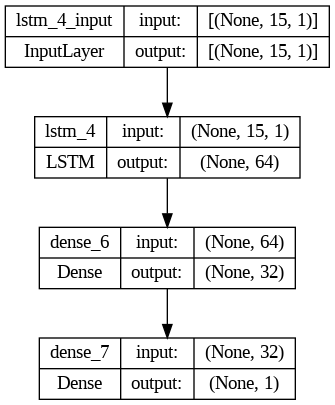

In [ ]:
model = Sequential()
model.add(LSTM(units = 64, input_shape=(n_step , features), return_sequences=False))
# model.add(Dropout(0.3))
# model.add(LSTM(units = 32, return_sequences=False))
# model.add(Dropout(0.3))
model.add(Dense(32))
model.add(Dense(units = 1))

model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.01))

plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

history_32 = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=100,
                    batch_size=32,
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/100
67/67 [==============================] - 8s 42ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 2/100
67/67 [==============================] - 1s 19ms/step - loss: 3.5190e-05 - val_loss: 0.0021
Epoch 3/100
67/67 [==============================] - 1s 18ms/step - loss: 3.5697e-05 - val_loss: 0.0029
Epoch 4/100
67/67 [==============================] - 1s 21ms/step - loss: 3.6508e-05 - val_loss: 0.0011
Epoch 5/100
67/67 [==============================] - 1s 10ms/step - loss: 4.1898e-05 - val_loss: 0.0012
Epoch 6/100
67/67 [==============================] - 1s 10ms/step - loss: 3.2891e-05 - val_loss: 8.7977e-04
Epoch 7/100
67/67 [==============================] - 1s 10ms/step - loss: 3.1722e-05 - val_loss: 9.2854e-04
Epoch 8/100
67/67 [==============================] - 1s 10ms/step - loss: 3.6315e-05 - val_loss: 8.1231e-04
Epoch 9/100
67/67 [==============================] - 1s 10ms/step - loss: 3.1588e-05 - val_loss: 4.4911e-04
Epoch 10/100
67/67 [==============================] 

# Phân tích

14/14 [==============================] - 0s 4ms/step
MAE: 386.86
MSE: 267160.11
MAPE: 0.02
RMSE: 516.88


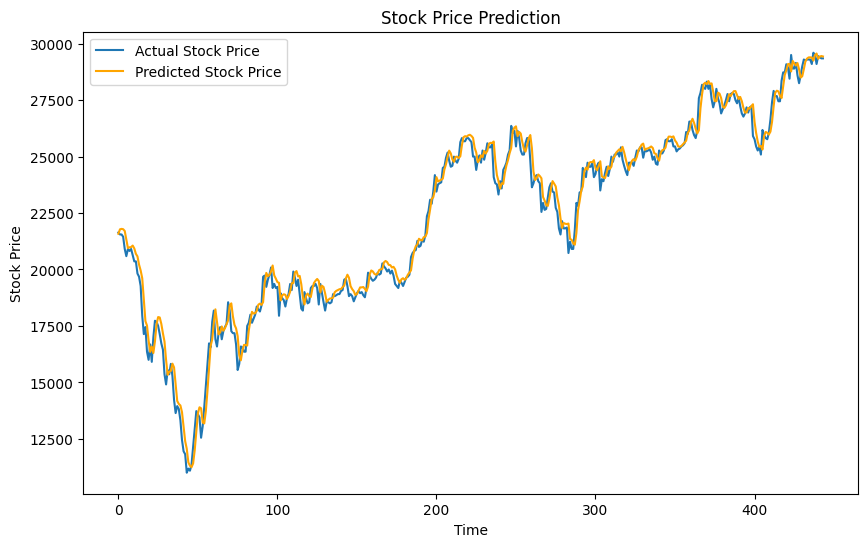

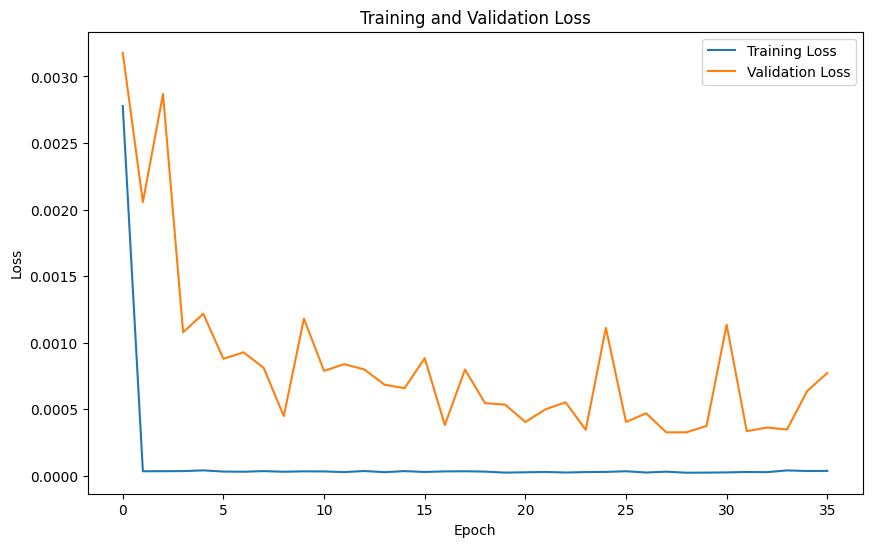

Final Training Loss: 0.0000
Final Validation Loss: 0.0008


In [ ]:
# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)

# Chuyển đổi dự đoán và giá trị thực về dạng ban đầu
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Tính toán các chỉ số đánh giá
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
# Tính toán RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Hiển thị kết quả
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'MAPE: {mape:.2f}')
print(f'RMSE: {rmse:.2f}')

# Vẽ biểu đồ kết quả dự đoán và giá trị thực tế
plt.figure(figsize=(10,6))
plt.plot(y_test, label='Actual Stock Price')
plt.plot(y_pred, label='Predicted Stock Price', color='orange')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Vẽ biểu đồ training loss và validation loss từ history
plt.figure(figsize=(10, 6))
plt.plot(history_32.history['loss'], label='Training Loss')
plt.plot(history_32.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# In ra giá trị loss của tập huấn luyện và tập validation
print(f"Final Training Loss: {history_32.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history_32.history['val_loss'][-1]:.4f}")

# Sử dụng model học máy

In [ ]:
company = 'HPG'

df =  stock_historical_data(symbol=company,
                            start_date="2012-03-20",
                            end_date='2024-06-20', resolution='1D', type='stock')

In [ ]:
df_Stock = pd.read_csv(f'{company}_data.csv', index_col=0, parse_dates=True)
df_Stock

,open,high,low,close,volume,ticker
time,,,,,,
2012-03-26,1200,1200,1180,1180,412710,HPG
2012-03-27,1170,1190,1170,1170,964010,HPG
2012-03-28,1160,1170,1160,1170,282250,HPG
2012-03-29,1160,1180,1160,1170,438730,HPG
2012-03-30,1180,1200,1170,1180,685020,HPG
...,...,...,...,...,...,...
2024-06-14,29500,29950,29100,29100,34292400,HPG
2024-06-17,29100,29950,29000,29450,34373100,HPG
2024-06-18,29500,29700,29400,29400,16534100,HPG


In [ ]:
df_Stock = df_Stock.drop(columns='ticker')
# df_Stock = df_Stock.drop(columns='volume')

In [ ]:
# df_Stock = df_Stock.drop(columns='time')
df_Stock

,open,high,low,close,volume
time,,,,,
2012-03-26,1200,1200,1180,1180,412710
2012-03-27,1170,1190,1170,1170,964010
2012-03-28,1160,1170,1160,1170,282250
2012-03-29,1160,1180,1160,1170,438730
2012-03-30,1180,1200,1170,1180,685020
...,...,...,...,...,...
2024-06-14,29500,29950,29100,29100,34292400
2024-06-17,29100,29950,29000,29450,34373100
2024-06-18,29500,29700,29400,29400,16534100


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR


def create_train_test_set(df_Stock):
    # Tách đặc trưng và mục tiêu
    features = df_Stock.drop(columns=['close'], axis=1)
    target = df_Stock['close']

    data_len = df_Stock.shape[0]
    print('Historical Stock Data length is - ', str(data_len))

    # Tạo điểm chia cho huấn luyện và kiểm tra
    train_split = int(data_len * 0.8)
    print('Training Set length - ', str(train_split))
    print('Test Set length - ', str(int(data_len * 0.2)))

    # Chia các đặc trưng và mục tiêu thành mẫu huấn luyện và kiểm tra
    X_train, X_test = features[:train_split], features[train_split:]
    y_train, y_test = target[:train_split], target[train_split:]

    # Chuẩn hóa dữ liệu
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_train = scaler_X.fit_transform(X_train)
    X_test = scaler_X.transform(X_test)

    y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

    # In ra kích thước của các tập dữ liệu
    print(X_train.shape, X_test.shape)
    print(y_train.shape, y_test.shape)

    return X_train, X_test, y_train, y_test, scaler_X, scaler_y


Prediction using Linear Regression

In [ ]:
X_train, X_test, Y_train, Y_test, scaler_X, scaler_y = create_train_test_set(df_Stock)

lr = LinearRegression()
lr.fit(X_train, Y_train)

Historical Stock Data length is -  3055
Training Set length -  2444
Test Set length -  611
(2444, 4) (611, 4)
(2444,) (611,)


LinearRegression()

MAE: 162.22
MSE: 45131.52
MAPE: 0.01
RMSE: 212.44

      Actual     Predicted
0    31720.0  31837.160041
1    31510.0  31475.129392
2    31510.0  31771.393571
3    31030.0  31100.191219
4    31790.0  31625.803812
..       ...           ...
606  29100.0  29535.699518
607  29450.0  29717.962061
608  29400.0  29539.671299
609  29350.0  29295.036557
610  29350.0  29101.660019

[611 rows x 2 columns]


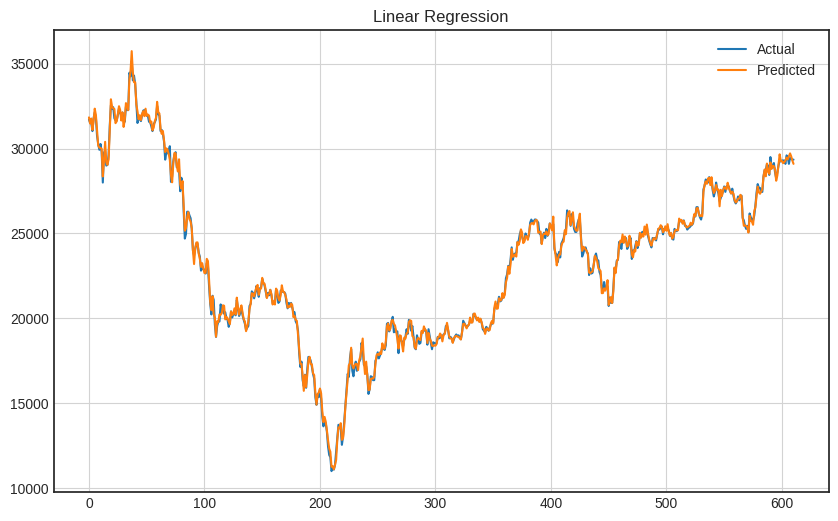

In [ ]:
Y_test_original = scaler_y.inverse_transform(Y_test.reshape(-1, 1)).flatten()
Y_test_original_list = Y_test_original.tolist()

Y_test_pred = lr.predict(X_test)
Y_test_pred = scaler_y.inverse_transform(Y_test_pred.reshape(-1, 1)).flatten()
Y_test_pred_list = Y_test_pred.tolist()

df_pred = pd.DataFrame({'Actual': Y_test_original_list, 'Predicted': Y_test_pred_list})

# Reset index if 'time' is present in your data (optional)
if 'time' in df_pred.columns:
    df_pred['time'] = pd.to_datetime(df_pred['time'], format='%Y-%m-%d')

df_pred[['Actual', 'Predicted']].plot()
plt.title("Linear Regression")

mae = mean_absolute_error(Y_test_original_list, Y_test_pred_list)
mse = mean_squared_error(Y_test_original_list, Y_test_pred_list)
mape = mean_absolute_percentage_error(Y_test_original_list, Y_test_pred_list)
rmse = np.sqrt(mean_squared_error(Y_test_original_list, Y_test_pred_list))

# Hiển thị kết quả
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'MAPE: {mape:.2f}')
print(f'RMSE: {rmse:.2f}')
print()

# Display the DataFrame
print(df_pred)

Prediction using SVM

In [ ]:
X_train, X_test, Y_train, Y_test, scaler_X, scaler_y = create_train_test_set(df_Stock)

svr_model = SVR(kernel='rbf')
svr_model.fit(X_train, Y_train)

Historical Stock Data length is -  3055
Training Set length -  2444
Test Set length -  611
(2444, 4) (611, 4)
(2444,) (611,)


SVR()

MAE: 526.96
MSE: 1433456.66
MAPE: 0.03
RMSE: 1197.27

      Actual     Predicted
0    31720.0  31844.131747
1    31510.0  31458.998398
2    31510.0  31472.520830
3    31030.0  30997.813862
4    31790.0  31039.455016
..       ...           ...
606  29100.0  29516.573961
607  29450.0  29391.676446
608  29400.0  29111.761637
609  29350.0  29049.795614
610  29350.0  29044.577898

[611 rows x 2 columns]


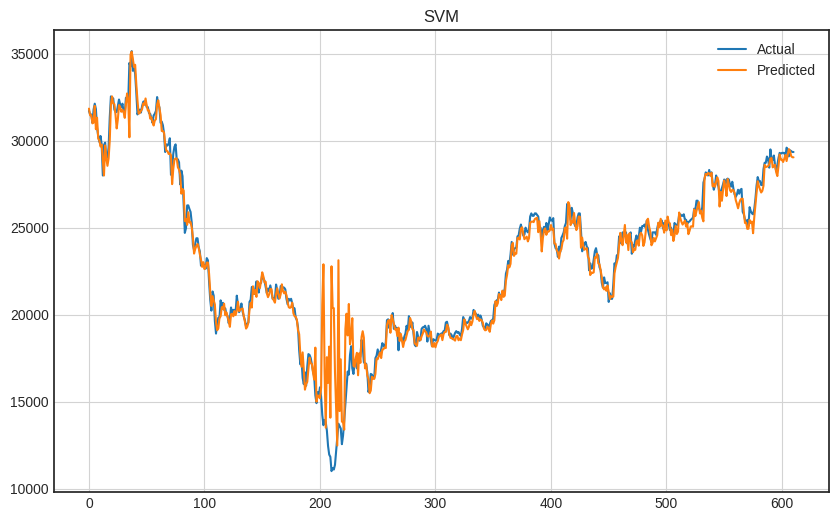

In [ ]:
Y_test_original = scaler_y.inverse_transform(Y_test.reshape(-1, 1)).flatten()
Y_test_original_list = Y_test_original.tolist()

Y_test_pred = svr_model.predict(X_test)
Y_test_pred = scaler_y.inverse_transform(Y_test_pred.reshape(-1, 1)).flatten()
Y_test_pred_list = Y_test_pred.tolist()

df_pred = pd.DataFrame({'Actual': Y_test_original_list, 'Predicted': Y_test_pred_list})

# Reset index if 'time' is present in your data (optional)
if 'time' in df_pred.columns:
    df_pred['time'] = pd.to_datetime(df_pred['time'], format='%Y-%m-%d')

df_pred[['Actual', 'Predicted']].plot()
plt.title("SVM")


mae = mean_absolute_error(Y_test_original_list, Y_test_pred_list)
mse = mean_squared_error(Y_test_original_list, Y_test_pred_list)
mape = mean_absolute_percentage_error(Y_test_original_list, Y_test_pred_list)
rmse = np.sqrt(mean_squared_error(Y_test_original_list, Y_test_pred_list))

# Hiển thị kết quả
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'MAPE: {mape:.2f}')
print(f'RMSE: {rmse:.2f}')
print()

# Display the DataFrame
print(df_pred)

Prediction using Random foreset

In [ ]:
X_train, X_test, Y_train, Y_test, scaler_X, scaler_y = create_train_test_set(df_Stock)

rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train, Y_train)

Historical Stock Data length is -  3055
Training Set length -  2444
Test Set length -  611
(2444, 4) (611, 4)
(2444,) (611,)


RandomForestRegressor(random_state=42)

MAE: 277.36
MSE: 134823.53
MAPE: 0.01
RMSE: 367.18

      Actual  Predicted
0    31720.0   31852.65
1    31510.0   31457.40
2    31510.0   31684.00
3    31030.0   31272.10
4    31790.0   31489.10
..       ...        ...
606  29100.0   29696.60
607  29450.0   29606.00
608  29400.0   29762.59
609  29350.0   29624.79
610  29350.0   29176.50

[611 rows x 2 columns]


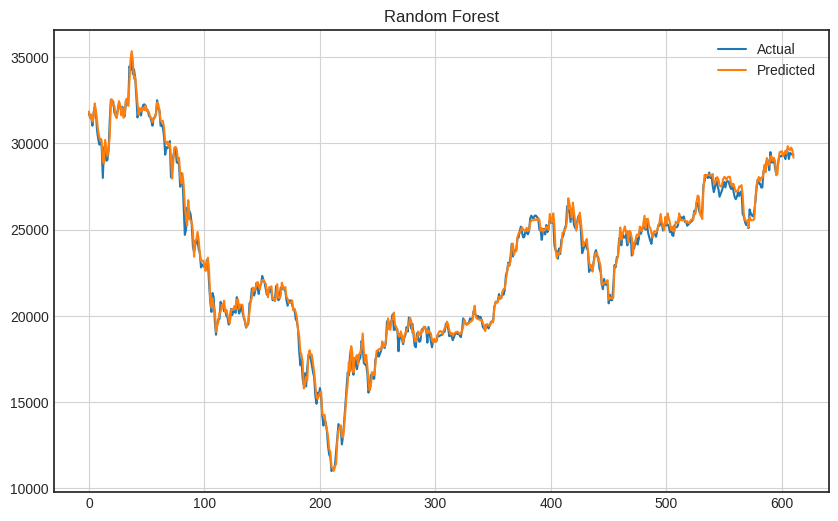

In [ ]:
Y_test_original = scaler_y.inverse_transform(Y_test.reshape(-1, 1)).flatten()
Y_test_original_list = Y_test_original.tolist()

Y_test_pred = rfr.predict(X_test)
Y_test_pred = scaler_y.inverse_transform(Y_test_pred.reshape(-1, 1)).flatten()
Y_test_pred_list = Y_test_pred.tolist()

df_pred = pd.DataFrame({'Actual': Y_test_original_list, 'Predicted': Y_test_pred_list})

# Reset index if 'time' is present in your data (optional)
if 'time' in df_pred.columns:
    df_pred['time'] = pd.to_datetime(df_pred['time'], format='%Y-%m-%d')

df_pred[['Actual', 'Predicted']].plot()
plt.title("Random Forest")

mae = mean_absolute_error(Y_test_original_list, Y_test_pred_list)
mse = mean_squared_error(Y_test_original_list, Y_test_pred_list)
mape = mean_absolute_percentage_error(Y_test_original_list, Y_test_pred_list)
rmse = np.sqrt(mean_squared_error(Y_test_original_list, Y_test_pred_list))

# Hiển thị kết quả
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'MAPE: {mape:.2f}')
print(f'RMSE: {rmse:.2f}')
print()

# Display the DataFrame
print(df_pred)

Prediction using Decision Trê

In [ ]:
X_train, X_test, Y_train, Y_test, scaler_X, scaler_y = create_train_test_set(df_Stock)

dtr = DecisionTreeRegressor(random_state=42)
dtr.fit(X_train, Y_train)

Historical Stock Data length is -  3055
Training Set length -  2444
Test Set length -  611
(2444, 4) (611, 4)
(2444,) (611,)


DecisionTreeRegressor(random_state=42)

MAE: 388.33
MSE: 262398.18
MAPE: 0.02
RMSE: 512.25

      Actual  Predicted
0    31720.0    31720.0
1    31510.0    31510.0
2    31510.0    31930.0
3    31030.0    31510.0
4    31790.0    31690.0
..       ...        ...
606  29100.0    29370.0
607  29450.0    29370.0
608  29400.0    30030.0
609  29350.0    30030.0
610  29350.0    29370.0

[611 rows x 2 columns]


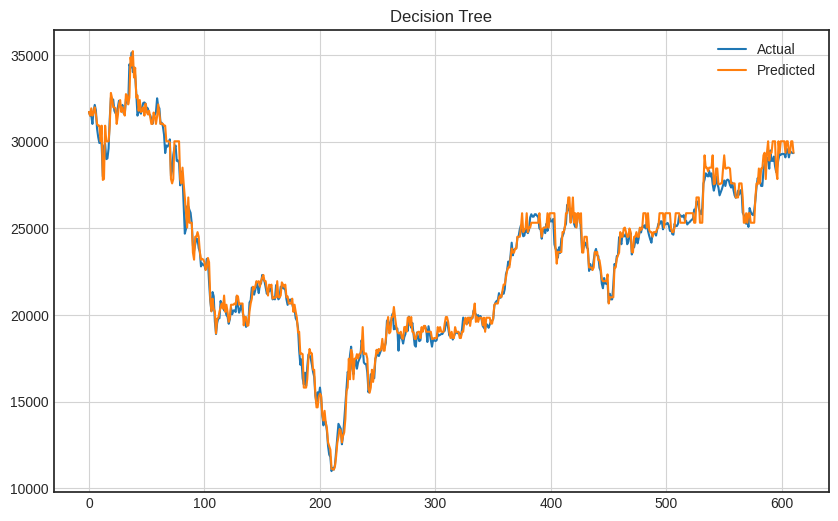

In [ ]:
Y_test_original = scaler_y.inverse_transform(Y_test.reshape(-1, 1)).flatten()
Y_test_original_list = Y_test_original.tolist()

Y_test_pred = dtr.predict(X_test)
Y_test_pred = scaler_y.inverse_transform(Y_test_pred.reshape(-1, 1)).flatten()
Y_test_pred_list = Y_test_pred.tolist()

df_pred = pd.DataFrame({'Actual': Y_test_original_list, 'Predicted': Y_test_pred_list})

# Reset index if 'time' is present in your data (optional)
if 'time' in df_pred.columns:
    df_pred['time'] = pd.to_datetime(df_pred['time'], format='%Y-%m-%d')

df_pred[['Actual', 'Predicted']].plot()
plt.title("Decision Tree")


mae = mean_absolute_error(Y_test_original_list, Y_test_pred_list)
mse = mean_squared_error(Y_test_original_list, Y_test_pred_list)
mape = mean_absolute_percentage_error(Y_test_original_list, Y_test_pred_list)
rmse = np.sqrt(mean_squared_error(Y_test_original_list, Y_test_pred_list))

# Hiển thị kết quả
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'MAPE: {mape:.2f}')
print(f'RMSE: {rmse:.2f}')
print()

# Display the DataFrame
print(df_pred)

Historical Stock Data length is -  3055
Training Set length -  2444
Test Set length -  611
(2444, 4) (611, 4)
(2444,) (611,)


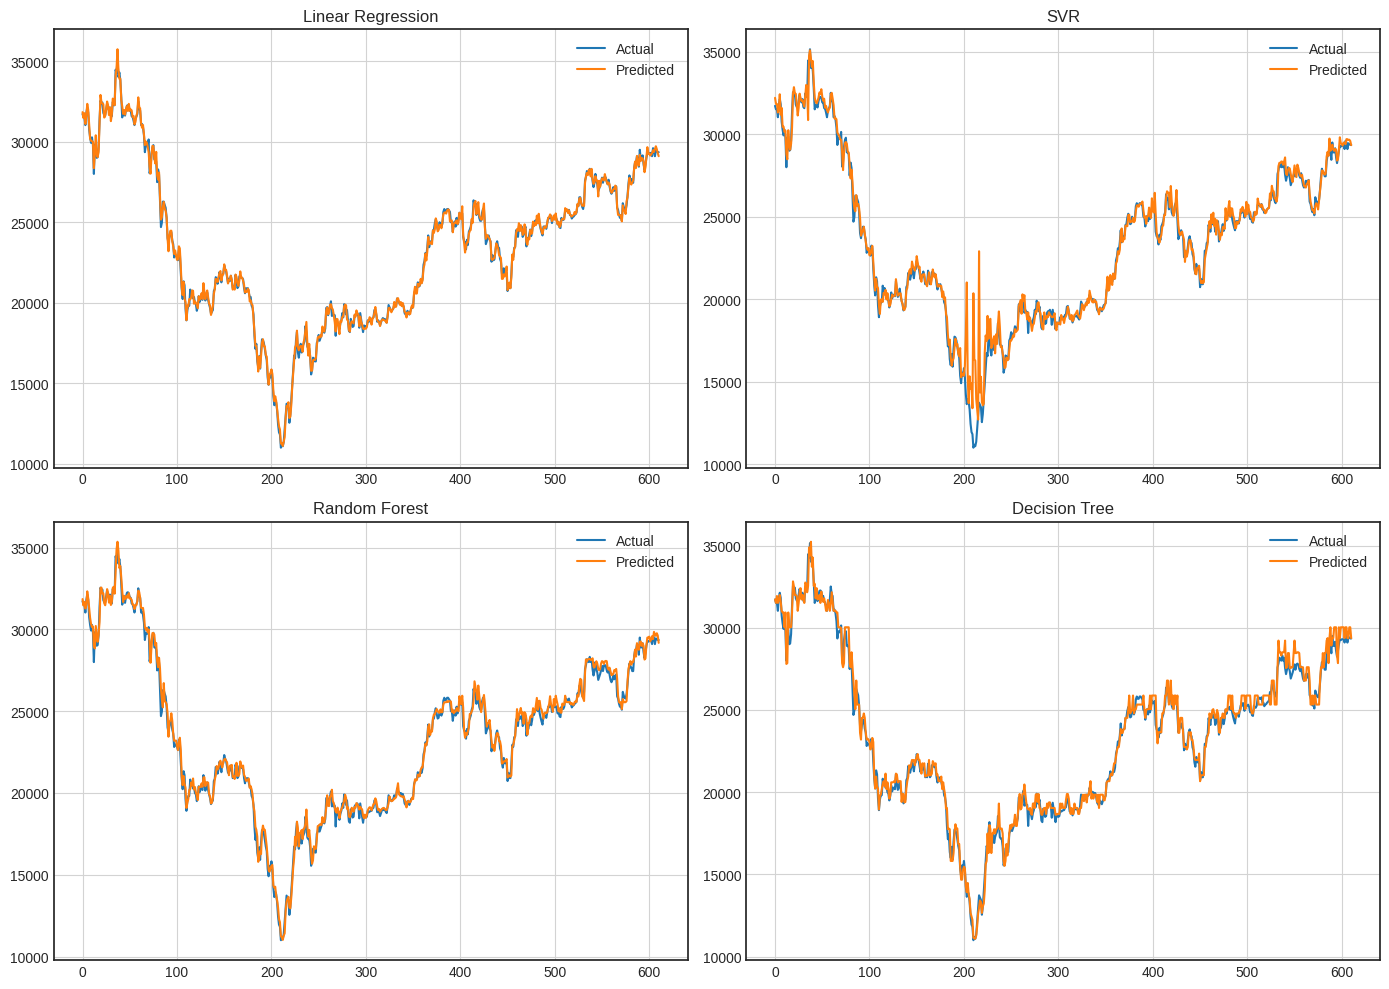

In [ ]:
X_train, X_test, y_train, y_test, scaler_X, scaler_y = create_train_test_set(df_Stock)
Y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Huấn luyện mô hình Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Dự đoán với Linear Regression
Y_test_pred_lr = lr.predict(X_test)
Y_test_pred_lr = scaler_y.inverse_transform(Y_test_pred_lr.reshape(-1, 1)).flatten()

# Huấn luyện mô hình SVR
svr_model = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_model.fit(X_train, y_train)

# Dự đoán với SVR
Y_test_pred_svr = svr_model.predict(X_test)
Y_test_pred_svr = scaler_y.inverse_transform(Y_test_pred_svr.reshape(-1, 1)).flatten()

#  Huấn luyện mô hình RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train, y_train)

# Dự đoán với RandomForestRegressor
Y_test_pred_rfr = rfr.predict(X_test)
Y_test_pred_rfr = scaler_y.inverse_transform(Y_test_pred_rfr.reshape(-1, 1)).flatten()

#  Huấn luyện mô hình DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state=42)
dtr.fit(X_train, y_train)

# Dự đoán với DecisionTreeRegressor
Y_test_pred_dtr = dtr.predict(X_test)
Y_test_pred_dtr = scaler_y.inverse_transform(Y_test_pred_dtr.reshape(-1, 1)).flatten()


# Tạo DataFrame để so sánh giá trị thực tế và giá trị dự đoán cho SVR
df_pred_svr = pd.DataFrame({'Actual': Y_test_original, 'Predicted': Y_test_pred_svr})

# Tạo DataFrame để so sánh giá trị thực tế và giá trị dự đoán cho Linear Regression
df_pred_lr = pd.DataFrame({'Actual': Y_test_original, 'Predicted': Y_test_pred_lr})

# Tạo DataFrame để so sánh giá trị thực tế và giá trị dự đoán cho RandomForestRegressor
df_pred_rfr = pd.DataFrame({'Actual': Y_test_original, 'Predicted': Y_test_pred_rfr})

# Tạo DataFrame để so sánh giá trị thực tế và giá trị dự đoán cho DecisionTreeRegressor
df_pred_dtr = pd.DataFrame({'Actual': Y_test_original, 'Predicted': Y_test_pred_dtr})


# Vẽ biểu đồ
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Linear Regression
axs[0, 0].plot(df_pred_lr['Actual'], label='Actual')
axs[0, 0].plot(df_pred_lr['Predicted'], label='Predicted')
axs[0, 0].set_title('Linear Regression')
axs[0, 0].legend()

# SVR
axs[0, 1].plot(df_pred_svr['Actual'], label='Actual')
axs[0, 1].plot(df_pred_svr['Predicted'], label='Predicted')
axs[0, 1].set_title('SVR')
axs[0, 1].legend()

# Random Forest
axs[1, 0].plot(df_pred_rfr['Actual'], label='Actual')
axs[1, 0].plot(df_pred_rfr['Predicted'], label='Predicted')
axs[1, 0].set_title('Random Forest')
axs[1, 0].legend()

# Decision Tree
axs[1, 1].plot(df_pred_dtr['Actual'], label='Actual')
axs[1, 1].plot(df_pred_dtr['Predicted'], label='Predicted')
axs[1, 1].set_title('Decision Tree')
axs[1, 1].legend()


# Để trống 2 ô còn lại
# for ax in axs[1]:
#     ax.axis('off')

plt.tight_layout()
plt.show()
